In [1]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path
import platform

# Comment here to add in for either mac or linux computer
if platform.system() == "Linux":   # for linux
    sys.path.extend(['/data/GitHub/NeuroPy']) 
    sys.path.extend(['/data/GitHub/TraceFC/'])
elif platform.system() == "Darwin":
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/TraceFC'])
elif platform.system() == "Windows":
    print('No windows repositories defined')

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.neuroscopeio import NeuroscopeIO
from neuropy.io.binarysignalio import BinarysignalIO 
from neuropy.io.miniscopeio import MiniscopeIO
from neuropy.core import Epoch
from neuropy.utils import plot_util
from neuropy.utils.signal_process import WaveletSg
from neuropy.plotting.spikes import plot_raster, plot_binned_raster
from neuropy.plotting.signals import plot_signal_w_epochs, plot_spectrogram
from neuropy.io.usvio import detect_tone

from tracefc.io.session_directory import get_session_dir

In [2]:
from neuropy.core.session import ProcessData

def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)

In [3]:
animal, sess_name = 'Finn2', 'training'
sess_dir = get_session_dir(animal, sess_name)
sess = sess_use(sess_dir)
print(sess.recinfo)

filename: /data3/Trace_FC/Recording_Rats/Finn2/2023_05_08_training/Finn2_training_denoised.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250



In [4]:
print(sess.eegfile)

duration: 19024.80 seconds 
duration: 5.28 hours 



# Read in DeepLabCut

In [5]:
import neuropy.io.dlcio as dlcio
dlc_path = '/data2/Trace_FC/Recording_Rats/Finn2/2023_05_08_training'
arena_side_pix = 60  # Keep this
arena_side_cm = 25.4  # Update this after measuring!!!
pix2cm = arena_side_cm / arena_side_pix

# Read in DLC data
sess.dlc = dlcio.DLC(dlc_path, pix2cm=pix2cm)

# Smooth position, get timestamps, and get speed
sess.dlc.get_timestamps('ms_webcam', include_str="2_training")
sess.dlc.smooth_pos(bodyparts=["crown_middle", "back_middle"])
sess.dlc.timestamps["Timestamps"] = sess.dlc.timestamps["Timestamps"].dt.tz_localize("America/Detroit")
sess.dlc.get_all_speed()

Using tracking file #1: /data2/Trace_FC/Recording_Rats/Finn2/2023_05_08_training/2_training/training/Finn2/gobears/2023_05_08/12_06_09/My_WebCam/Finn2_training_combined_movieDLC_resnet50_TraceFC_shockboxFeb28shuffle1_500000.h5


,back_middle,crown_middle,left_ear,neck_base,nose,right_ear,tail_base,tail_end,tail_middle
0,NaN,NaN,844.489094,0.637159,12.108097,3.873071,2.887589,1.702280,2.844129
1,NaN,NaN,2.728748,6.160706,4.046535,801.034192,1.108562,3.161103,856.491742
2,NaN,NaN,0.500291,2.127942,1.246952,0.620738,1.281399,0.614405,2.149913
3,NaN,NaN,0.877834,2.103166,3.651505,1.050498,1.206689,1.127960,1.574230
4,NaN,NaN,1.797900,6.230801,3.878855,1.498497,1.641239,5.458072,4.703678
...,...,...,...,...,...,...,...,...,...
60617,NaN,NaN,2.342981,2.035985,3.616565,3.543801,2.648206,2.935423,0.528693
60618,NaN,NaN,0.901130,3.763110,2.284191,2.792867,3.369633,4.665316,0.266581
60619,NaN,NaN,2.506586,1.486250,2.946650,1.967454,0.868466,4.269405,1.141732
60620,NaN,NaN,2.603536,2.204713,2.971853,2.717636,0.843302,3.255342,0.808295


In [6]:
# Load in openephys times to sync
import neuropy.io.openephysio as oeio
sync_df = oeio.create_sync_df(sess.basepath)
sync_df["Total seconds from start"] = (sync_df["Datetime"] - sync_df["Datetime"][0]).dt.total_seconds()

# sync DLC times to your eeg file
sess.dlc.timestamps["Total seconds from OE start"] = (sess.dlc.timestamps["Timestamps"] - sync_df["Datetime"][0]).dt.total_seconds()
sess.dlc.timestamps["eeg_time"] = np.interp(sess.dlc.timestamps["Total seconds from OE start"], sync_df["Total seconds from start"], 
                                            sync_df["eeg_time"])
sess.dlc.timestamps

start time = 2023-05-08 11:54:10-04:00
start time = 2023-05-08 12:04:32-04:00
start time = 2023-05-08 12:41:12-04:00
start time = 2023-05-08 14:15:17-04:00
start time = 2023-05-08 15:12:40-04:00


,Frame Number,Time Stamp (ms),Buffer Index,Timestamps,Total seconds from OE start,eeg_time
0,0,-29,0,2023-05-08 12:06:09.042000-04:00,719.042,641.417941
1,1,2,0,2023-05-08 12:06:09.073000-04:00,719.073,641.448941
2,2,34,0,2023-05-08 12:06:09.105000-04:00,719.105,641.480941
3,3,70,0,2023-05-08 12:06:09.141000-04:00,719.141,641.516941
4,4,98,0,2023-05-08 12:06:09.169000-04:00,719.169,641.544941
...,...,...,...,...,...,...
60617,60617,2026409,0,2023-05-08 12:39:55.480000-04:00,2745.480,2667.854707
60618,60618,2026450,0,2023-05-08 12:39:55.521000-04:00,2745.521,2667.895707
60619,60619,2026473,0,2023-05-08 12:39:55.544000-04:00,2745.544,2667.918707
60620,60620,2026521,0,2023-05-08 12:39:55.592000-04:00,2745.592,2667.966707


In [7]:
# Last calculate freezing times and plot again to check
frz_thresh = 0.25 # cm/sec  Adjust this to something that looks reasonable!
duration_thresh = 1 # sec, must be below the threshold above for at least that long to be considered freezing
bodypart_use = "crown_middle"
frz_bool = sess.dlc.speed[bodypart_use] < frz_thresh
frz_epochs = Epoch.from_boolean_array(frz_bool, t=sess.dlc.timestamps["eeg_time"])
frz_df = frz_epochs.to_dataframe()
frz_df = frz_df[frz_epochs.durations > duration_thresh]
frz_epochs = Epoch(frz_df)
frz_epochs

261 epochs
Snippet: 
          start         stop  duration label
0   839.399820   843.275818  3.875998  high
1   844.903817   846.480816  1.576999  high
2   868.695802   869.704802  1.008999  high
3   869.799802   871.871801  2.071999  high
4  1006.374719  1007.548718  1.173999  high

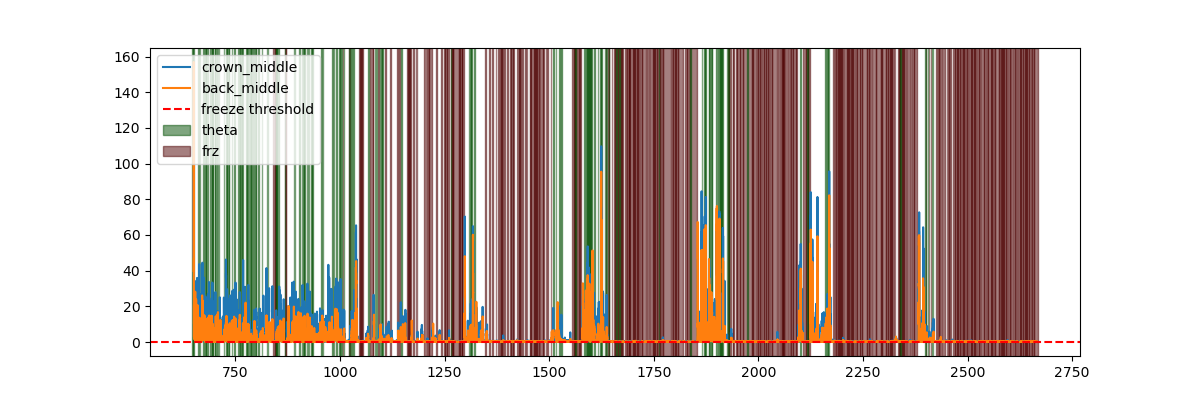

In [8]:
%matplotlib widget
# Plot to check! Looks ok, though there might be some mismatches between theta and movement.

_, ax = plt.subplots(figsize=(12, 4))
hc, = ax.plot(sess.dlc.timestamps["eeg_time"], sess.dlc.speed["crown_middle"])
hb, = ax.plot(sess.dlc.timestamps["eeg_time"], sess.dlc.speed["back_middle"])
hthresh = ax.axhline(frz_thresh, color='r', linestyle='--')

for start, stop in zip(frz_epochs.starts, frz_epochs.stops):
    hf = ax.axvspan(start, stop, color=[0.3, 0, 0, 0.5])

# Now plot theta epochs over it to triple check!
theta_epochs_file = sess.filePrefix.with_suffix(".theta_epochs.npy")
theta_epochs = Epoch(epochs=None, file=theta_epochs_file)
theta_epochs = theta_epochs.time_slice(t_start = sess.dlc.timestamps["eeg_time"].min(), t_stop=sess.dlc.timestamps["eeg_time"].max())

for start, stop in zip(theta_epochs.starts, theta_epochs.stops):
    htheta = ax.axvspan(start, stop, color=[0, 0.3, 0, 0.5])

ax.legend((hc, hb, hthresh, htheta, hf), ("crown_middle", "back_middle", "freeze threshold", "theta", "frz"))

,channel_states,timestamps,datetimes,event_name
913,2,4332188,2023-05-08 11:56:34.406266667,
1062,-2,4629812,2023-05-08 11:56:44.327066667,
2102,2,6730372,2023-05-08 11:57:54.345733333,
2250,-2,7028594,2023-05-08 11:58:04.286466667,
3200,2,8946301,2023-05-08 11:59:08.210033333,


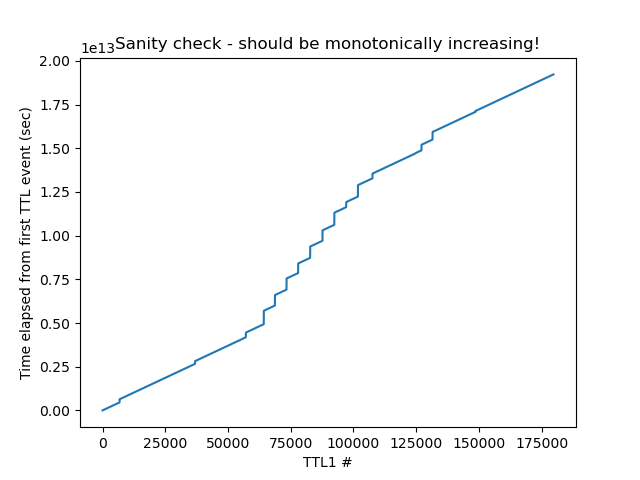

In [9]:
import neuropy.io.openephysio as oeio

# Import TTLs for CS from OpenEphys
ttl_df = oeio.load_all_ttl_events(sess.basepath, sanity_check_channel=1, zero_timestamps=True)
ttl_df[ttl_df['channel_states'].abs() == 2].head(5)

In [10]:
accurate_start_time = ttl_df[ttl_df['channel_states'].abs() == 1].iloc[6355]['datetimes']
accurate_start_time = accurate_start_time.tz_localize('America/Detroit')

In [11]:
approx_start_time = sess.dlc.timestamps.loc[0, 'Timestamps']
approx_start_time

Timestamp('2023-05-08 12:06:09.042000-0400', tz='America/Detroit')

In [12]:
adj_time_delta = (accurate_start_time - approx_start_time).total_seconds()
adj_time_delta

-207.957934

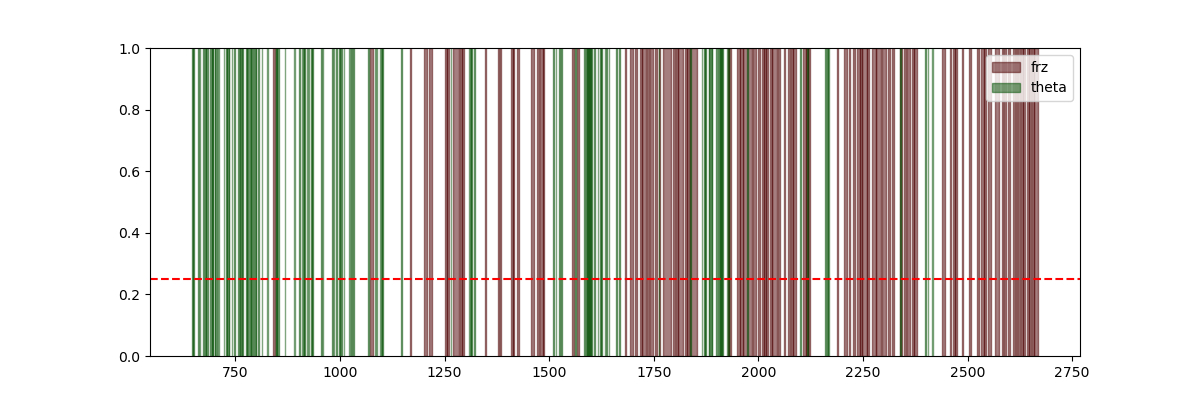

In [13]:
#Freezing and theta
from copy import deepcopy

manually_adjust_dlc_times = -0.528  
dlcadj = deepcopy(sess.dlc)
dlcadj.timestamps["eeg_time"] = dlcadj.timestamps["eeg_time"] + manually_adjust_dlc_times

_, ax = plt.subplots(figsize=(12, 4))
hthresh = ax.axhline(frz_thresh, color='r', linestyle='--')

for start, stop in zip(frz_epochs.starts, frz_epochs.stops):
    duration = stop - start
    if duration > 3:  # Check if the frz epoch duration is greater than 5 seconds
        hf = ax.axvspan(start, stop, color=[0.3, 0, 0, 0.5], label='frz')

theta_epochs_file = sess.filePrefix.with_suffix(".theta_epochs.npy")
theta_epochs = Epoch(epochs=None, file=theta_epochs_file)
theta_epochs = theta_epochs.time_slice(t_start=dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())

beta_epochs_file = sess.filePrefix.with_suffix(".beta_epochs.npy")
beta_epochs = Epoch(epochs=None, file=beta_epochs_file)
beta_epochs = beta_epochs.time_slice(t_start=dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())

for start, stop in zip(theta_epochs.starts, theta_epochs.stops):
    htheta = ax.axvspan(start, stop, color=[0, 0.3, 0, 0.5], label='theta')
    
    
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  
ax.legend(by_label.values(), by_label.keys())


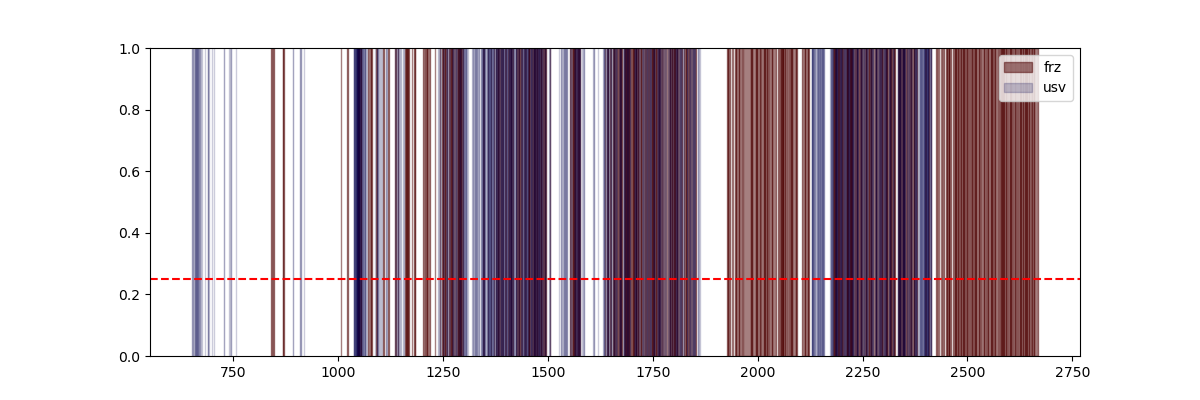

In [14]:
#Freezing and USV
from copy import deepcopy

manually_adjust_dlc_times = -0.528 
dlcadj = deepcopy(sess.dlc)
dlcadj.timestamps["eeg_time"] = dlcadj.timestamps["eeg_time"] + manually_adjust_dlc_times

_, ax = plt.subplots(figsize=(12, 4))
hthresh = ax.axhline(frz_thresh, color='r', linestyle='--')

for start, stop in zip(frz_epochs.starts, frz_epochs.stops):
    duration = stop - start
    hf = ax.axvspan(start, stop, color=[0.3, 0, 0, 0.5], label='frz')
    

# theta_epochs_file = sess.filePrefix.with_suffix(".theta_epochs.npy")
# theta_epochs = Epoch(epochs=None, file=theta_epochs_file)
# theta_epochs = theta_epochs.time_slice(t_start=dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())

usv_epochs_file = sess.filePrefix.with_suffix(".usv_epochs.npy")
usv_epochs = Epoch(epochs=None, file=usv_epochs_file)
usv_epochs


# delta_epochs_file = sess.filePrefix.with_suffix(".delta_epochs.npy")
# delta_epochs = Epoch(epochs=None, file=delta_epochs_file)
# delta_epochs = delta_epochs.time_slice(t_start=dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())


    
for start, stop in zip(usv_epochs.starts, usv_epochs.stops):
    duration = stop-start

    husv = ax.axvspan(start, stop, color=[0, 0, 0.3, 0.2], label='usv')
    
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  
ax.legend(by_label.values(), by_label.keys())

In [15]:
usv_epochs

457 epochs
Snippet: 
         start        stop  Begin_Time   Freq_Min  Duration  Freq_Range  Score  \
0  652.529394  652.563925   37.946853  39.274313  0.034535   20.924947    1.0   
1  652.676857  652.722485   38.094337  40.405391  0.045634   18.889006    1.0   
2  653.508978  653.542528   38.926574  46.196915  0.033555   12.441860    1.0   
3  655.169906  655.224620   40.587737  39.726744  0.054721   17.418605    1.0   
4  656.243937  656.292611   41.661918  37.917019  0.048681   41.171247    1.0   

   Accept label  
0       1        
1       1        
2       1        
3       1        
4       1        

## Save notebook to animal working directory

In [16]:
from neuropy.utils.manipulate_files import save_notebook
try:
    save_notebook(sess.basepath, save_prepend=f"{animal}_{sess_name}_")
except PermissionError:
    print('Got a weird PermissionError. Check to make sure file saved successfully')

/data/GitHub/TraceFC/Notebooks/Animal_files/Training notebooks/Sync_USV_and_Ephys(Finn2).ipynb saved to /data3/Trace_FC/Recording_Rats/Finn2/2023_05_08_training/Finn2_training_Sync_USV_and_Ephys(Finn2).ipynb


### Load in disconnect and motion artifacts

In [17]:
from neuropy.analyses.artifact import detect_artifact_epochs
signal = sess.eegfile.get_signal()
buffer_add = 0.25  # seconds, None = don't add

art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")
if art_epochs_file.exists():
    art_epochs = Epoch(epochs=None, file=art_epochs_file)
    print('Existing artifact epochs file loaded')
else:
    # art_epochs = detect_artifact_epochs(signal, thresh=8, 
    #                                 edge_cutoff=3, merge=6)

    # Pick a particular channel with the code below
    art_epochs = detect_artifact_epochs(signal.time_slice(channel_id=31), thresh=11, 
                                    edge_cutoff=3, merge=6)

    if buffer_add is not None:  # Add in buffer to prevent erroneous detection of start/stop of artifact as SWRs
        art_epochs.add_epoch_buffer(buffer_add)
    sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
    art_epochs.save(art_epochs_file)

print(f'Total artifact time = {art_epochs.durations.sum():0.1F} seconds')
art_epochs.to_dataframe()

Existing artifact epochs file loaded
Total artifact time = 45.6 seconds


/home/bowenw/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


,start,stop,label,duration
0,650.5812,651.1516,,0.5704
1,823.7372,824.5060,,0.7688
2,854.9204,855.7524,,0.8320
3,880.9212,881.6164,,0.6952
4,1036.9284,1038.4908,,1.5624
5,1296.6212,1298.4532,,1.8320
6,1578.6364,1580.2220,,1.5856
7,1853.5348,1855.0572,,1.5224
8,2123.3764,2124.9532,,1.5768
9,2382.0612,2383.6300,,1.5688


<Axes: >

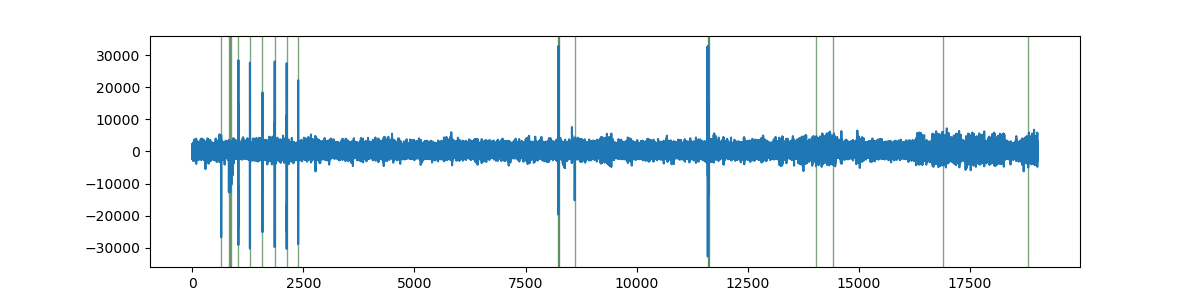

In [18]:
%matplotlib widget
chan_plot = 28
plot_signal_w_epochs(signal, 28, art_epochs)

## Define probe group

/data3/Trace_FC/Recording_Rats/Finn2/2023_05_08_training/Finn2_training_denoised.probegroup.npy saved


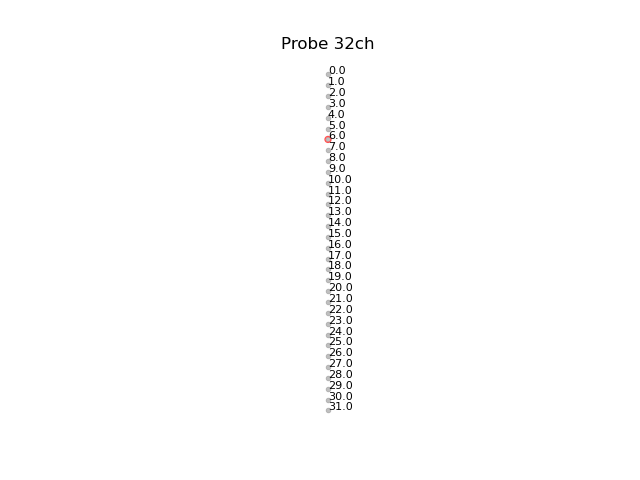

In [19]:
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe
shank = Shank()
shank = shank.auto_generate(columns=1, contacts_per_column=32, xpitch=0,
                   ypitch=20, channel_id=np.arange(31, -1, -1))
shank.set_disconnected_channels(sess.recinfo.skipped_channels)
probe = Probe(shank)
prbgrp = ProbeGroup()
prbgrp.add_probe(probe)
plot_probe(prbgrp)
prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
prbgrp.save(prbgrp.filename)
sess.prbgrp = prbgrp

## Detect Theta epochs

In [20]:
from neuropy.analyses.oscillations import detect_theta_epochs
mindur=1
maxdur=20
thresh = (1, None)
sigma = 0.125
edge_cutoff = 0.25
theta_channel = 7

# use this if you don't know theta channel
if theta_channel is None:
    theta_epochs, theta_power = detect_theta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    signal_use = signal.time_slice(channel_id=theta_channel)
    theta_epochs, theta_power = detect_theta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)

Best channel for theta: [7]
1502 epochs remaining with durations within (1,20)


## Detect SWR Epochs

In [21]:
from neuropy.analyses.oscillations import detect_ripple_epochs
ripple_channel = 7
thresh = (2, None)  # conservative but good
edge_cutoff = 0.5
ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                     ignore_epochs=art_epochs)


Selected channels for ripples: [7]
15273 epochs remaining with durations within (0.05,0.45)


# Detect Delta

In [22]:
#Detect Delta
from neuropy.analyses.oscillations import detect_hpc_delta_wave_epochs
min_dur = 0.15  
max_dur = 0.5   
ignore_epochs = None  
delta_channel = 7  

freq_band = (0.5, 4)

if delta_channel is not None:
    signal_use = signal.time_slice(channel_id=delta_channel)
else:
    signal_use = signal
delta_epochs = detect_hpc_delta_wave_epochs(
    signal_use, freq_band=freq_band, min_dur=min_dur, max_dur=max_dur, ignore_epochs=ignore_epochs
)

3238 delta waves detected


In [23]:
#Detect Beta
from neuropy.analyses.oscillations import detect_beta_epochs
mindur=1
maxdur=20
thresh = (1, None)
sigma = 0.125
edge_cutoff = 0.25
beta_channel = 7
  
if beta_channel is None:
    beta_epochs, beta_power = detect_beta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    signal_use = signal.time_slice(channel_id=beta_channel)
    beta_epochs, beta_power = detect_beta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)

Best channel for beta: [7]
1324 epochs remaining with durations within (1,20)


In [24]:
#Detect gamma
from neuropy.analyses.oscillations import detect_gamma_epochs
from neuropy.analyses.oscillations import Gamma
band=(40, 80)
lowthresh = 1.5  
highthresh = 3 
minDistance = 300
minDuration = 125
gamma_channel = 7

# Use this if you don't know the specific channel for gamma detection
if gamma_channel is None:
    signal_use = signal.time_slice(channel_id=gamma_channel)
else:
    # If a specific channel for gamma is known
    signal_use = signal

gammadetect = Gamma()
peakevents, gamma_amp = Gamma().get_peak_intervals(signal_use.traces[gamma_channel, :], band=band, lowthresh=lowthresh, highthresh=highthresh, 
                                        minDistance=minDistance, minDuration=minDuration, return_amplitude=True)
# csd=csd(self, period, refchan, band=band, window=1250)

## Sync via CS+ or CS- times in tone_recall or control_tone_recall or tone_habituation session

,channel_states,timestamps,datetimes,event_name
913,2,4332188,2023-05-08 11:56:34.406266667,
1062,-2,4629812,2023-05-08 11:56:44.327066667,
2102,2,6730372,2023-05-08 11:57:54.345733333,
2250,-2,7028594,2023-05-08 11:58:04.286466667,
3200,2,8946301,2023-05-08 11:59:08.210033333,


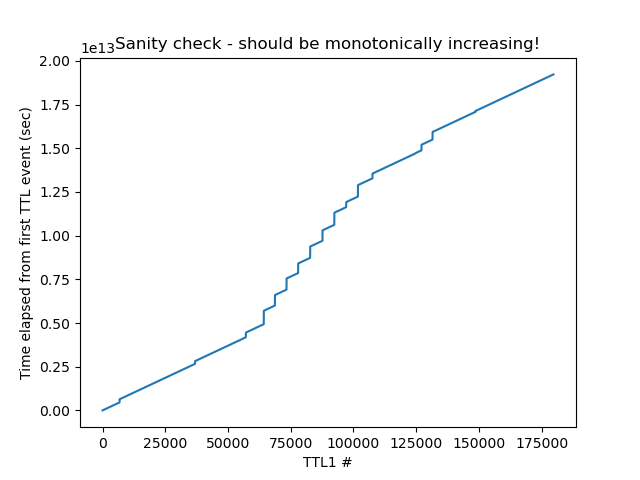

In [25]:
import neuropy.io.openephysio as oeio

# Import TTLs for CS from OpenEphys
ttl_df = oeio.load_all_ttl_events(sess.basepath, sanity_check_channel=1, zero_timestamps=True)
ttl_df[ttl_df['channel_states'].abs() == 2].head(5)

In [26]:
import tracefc.io.traceio as traceio

if "training" in str(sess.basepath):
    # For tone habituation
    csn_starts, csn_stops, csn_df = traceio.load_trace_events(sess.basepath, session_type="tone_habituation", 
                                                          event_type="CS-", return_df=True)
    print(f'{csn_starts.shape[0]} CS- events detected')
    print(csn_starts.head(6))
    
    # For CS+ during training
    cs_starts, cs_stops, cs_df = traceio.load_trace_events(sess.basepath, session_type="training", 
                                                          event_type="CS+", return_df=True)
    print(f'{cs_starts.shape[0]} CS+ events detected')
    print(cs_starts.head(6))
elif "recall" in str(sess.basepath):
    # For tone recall CS+
    cs_starts, cs_stops, cs_df = traceio.load_trace_events(sess.basepath, session_type="tone_recall", 
                                                          event_type="CS+", return_df=True)
    print(f'{cs_starts.shape[0]} CS+ events detected')
    print(cs_starts.head(6))
    
    # For control tone recall CS-
    csn_starts, csn_stops, csn_df = traceio.load_trace_events(sess.basepath, session_type="control_tone_recall", 
                                                          event_type="CS-", return_df=True)
    print(f'{csn_starts.shape[0]} CS- events detected')
    print(csn_starts.head(6))

5 CS- events detected
      Time (s)      Event                     Timestamp
5    61.580098  CS1_start 2023-05-08 11:56:34.516826675
7   141.519549  CS2_start 2023-05-08 11:57:54.456278131
9   215.384520  CS3_start 2023-05-08 11:59:08.321249054
11  278.086569  CS4_start 2023-05-08 12:00:11.023298309
13  358.010654  CS5_start 2023-05-08 12:01:30.947383211
6 CS+ events detected
       Time (s)      Event                     Timestamp
6    365.882155  CS1_start 2023-05-08 12:12:14.912075418
16   625.563774  CS2_start 2023-05-08 12:16:34.593693870
26   907.587123  CS3_start 2023-05-08 12:21:16.617043156
36  1182.504313  CS4_start 2023-05-08 12:25:51.534232992
46  1452.332576  CS5_start 2023-05-08 12:30:21.362496036
56  1711.011817  CS6_start 2023-05-08 12:34:40.041737217


In [27]:
sync_df = oeio.create_sync_df(sess.basepath)
sync_df

start time = 2023-05-08 11:54:10-04:00
start time = 2023-05-08 12:04:32-04:00
start time = 2023-05-08 12:41:12-04:00
start time = 2023-05-08 14:15:17-04:00
start time = 2023-05-08 15:12:40-04:00


,Recording,Datetime,Condition,nframe_dat,dat_time,nframe_eeg,eeg_time
0,0,2023-05-08 11:54:10-04:00,start,0,0.000000,0,0.0000
1,0,2023-05-08 12:03:14.375433333-04:00,stop,16331263,544.375433,680469,544.3752
2,1,2023-05-08 12:04:32-04:00,start,16331264,544.375467,680470,544.3760
3,1,2023-05-08 12:40:06.536500-04:00,stop,80367359,2678.911967,3348639,2678.9112
4,2,2023-05-08 12:41:12-04:00,start,80367360,2678.912000,3348640,2678.9120
5,2,2023-05-08 14:13:58.532233333-04:00,stop,247363327,8245.444233,10306805,8245.4440
6,3,2023-05-08 14:15:17-04:00,start,247363328,8245.444267,10306806,8245.4448
7,3,2023-05-08 15:11:31.677300-04:00,stop,348603647,11620.121567,14525151,11620.1208
8,4,2023-05-08 15:12:40-04:00,start,348603648,11620.121600,14525152,11620.1216
9,4,2023-05-08 17:16:04.680500-04:00,stop,570744063,19024.802100,23781002,19024.8016


In [28]:
# Grab CS times corresponding to OE timestamps
ttl_lag_use = pd.Timedelta(0.8, unit="seconds")
cs_oe_start_df = traceio.trace_ttl_to_openephys(cs_starts, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use)
cs_oe_stop_df = traceio.trace_ttl_to_openephys(cs_stops, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use)
# Convert to times in combined eeg file
cs_starts_combined = oeio.recording_events_to_combined_time(cs_oe_start_df, sync_df)
cs_stops_combined = oeio.recording_events_to_combined_time(cs_oe_stop_df, sync_df)

csn_oe_start_df = traceio.trace_ttl_to_openephys(csn_starts, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use*2)
csn_oe_stop_df = traceio.trace_ttl_to_openephys(csn_stops, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use*2)

# Convert to times in combined eeg file
csn_starts_combined = oeio.recording_events_to_combined_time(csn_oe_start_df, sync_df)
csn_stops_combined = oeio.recording_events_to_combined_time(csn_oe_stop_df, sync_df)

start time lag: mean = -0.40930200366666664, std = 0.0012269775854382478
start time lag: mean = -0.40964181983333336, std = 0.0012354090779131128
start time lag: mean = -0.1110670762, std = 0.000495073273146712
start time lag: mean = -0.1116098198, std = 0.00024922923703229506


/data/GitHub/TraceFC/tracefc/io/traceio.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace_cs_sync_df.loc[:, "datetimes"] = trace_cs_sync_df["datetimes"].dt.tz_localize(


In [29]:
cs_starts

,Time (s),Event,Timestamp
6,365.882155,CS1_start,2023-05-08 12:12:14.912075418
16,625.563774,CS2_start,2023-05-08 12:16:34.593693870
26,907.587123,CS3_start,2023-05-08 12:21:16.617043156
36,1182.504313,CS4_start,2023-05-08 12:25:51.534232992
46,1452.332576,CS5_start,2023-05-08 12:30:21.362496036
56,1711.011817,CS6_start,2023-05-08 12:34:40.041737217


In [30]:
cs_stops

,Time (s),Event,Timestamp
7,375.799134,CS1_end,2023-05-08 12:12:24.829054254
17,635.497616,CS2_end,2023-05-08 12:16:44.527536291
27,917.526423,CS3_end,2023-05-08 12:21:26.556342739
37,1192.425262,CS4_end,2023-05-08 12:26:01.455181736
47,1462.273861,CS5_end,2023-05-08 12:30:31.303780931
57,1720.953102,CS6_end,2023-05-08 12:34:49.983021635


In [31]:
cs_oe_start_df

,channel_states,timestamps,datetimes,event_name
5428,2,13875131,2023-05-08 12:12:14.504366667-04:00,
9284,2,21665565,2023-05-08 12:16:34.185500-04:00,
13472,2,30126239,2023-05-08 12:21:16.207966667-04:00,
17554,2,38373739,2023-05-08 12:25:51.124633333-04:00,
21561,2,46468565,2023-05-08 12:30:20.952166667-04:00,
25402,2,54228925,2023-05-08 12:34:39.630833333-04:00,


### How to write CS+ to neuroscope event file

In [32]:
cs_tone_recall_epochs = Epoch({"start": cs_starts_combined, "stop": cs_stops_combined, "label": ["CS+"]*len(cs_starts_combined)})
cs_tone_recall_epochs
sess.recinfo.write_epochs(cs_tone_recall_epochs, "cs+")

In [33]:
cs_tone_recall_epochs

6 epochs
Snippet: 
          start         stop label
0  1006.880366  1016.796866   CS+
1  1266.561500  1276.495033   CS+
2  1548.583966  1558.523066   CS+
3  1823.500633  1833.421233   CS+
4  2093.328166  2103.269300   CS+

In [34]:
sess_use

<function __main__.sess_use(basepath='/data/GitHub/TraceFC/Notebooks/Animal_files/Training notebooks')>

In [35]:
sess.basepath

PosixPath('/data3/Trace_FC/Recording_Rats/Finn2/2023_05_08_training')

/data3/Trace_FC/Recording_Rats/Finn2/2023_05_08_training/2_training/shockbox/T0000001.wav
Mean start lag time of 614.644 sec with std = 0.073 sec. Add lags from wavfile times to get ephys times
Mean stop lag time of 614.230 sec with std = 0.059 sec.


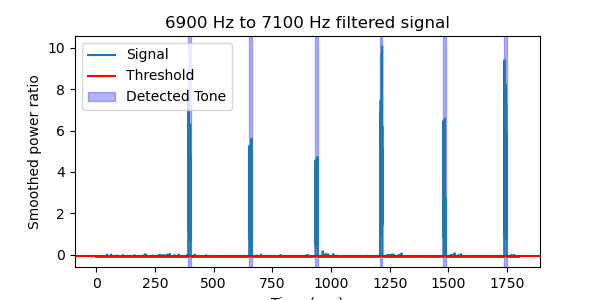

In [36]:
# Detect CS+ in audio recording.
from tracefc.io.traceio import grab_usv_folder
csp_wav = grab_usv_folder(sess.basepath, 'csp')
print(csp_wav)
# Get CS+ times and plot to check
cs_wav_epochs, cs_wav_stop = detect_tone(csp_wav, freq_lims=(6900, 7100), thresh=-0.08, tone_length=5, tone_label="CS+", 
                                         plot_check=True, return_stop=True)
# Check that lags are consistent
cs_start_lags = cs_starts_combined - cs_wav_epochs.starts
print(f"Mean start lag time of {np.mean(cs_start_lags):0.3F} sec with std = {np.std(cs_start_lags):0.3F} sec. Add lags from wavfile times to get ephys times")
cs_stop_lags = cs_stops_combined - cs_wav_epochs.stops
print(f"Mean stop lag time of {np.mean(cs_stop_lags):0.3F} sec with std = {np.std(cs_stop_lags):0.3F} sec.")

Ditto for CS-

/data3/Trace_FC/Recording_Rats/Finn2/2023_05_08_training/1_tone_habituation/restbox/tone_habituation/T0000001.wav
Mean start lag time of 97.337 sec with std = 0.028 sec. Add lags from wavfile times to get ephys times
Mean stop lag time of 96.883 sec with std = 0.079 sec.


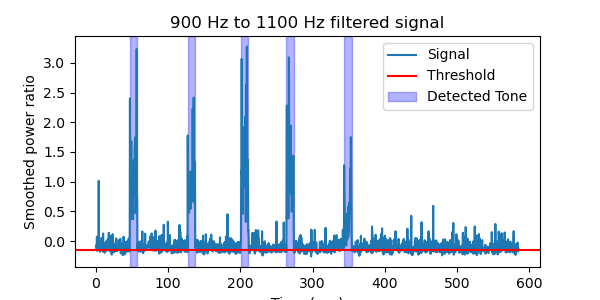

In [37]:
# Detect CS- in audio recording.
if "training" in str(sess.basepath):
    # csn_wav = sorted((sess.basepath / "1_tone_habituation").glob("**/*.wav"))[0]
    csn_wav = grab_usv_folder(sess.basepath, 'csn')
print(csn_wav)

# Get CS+ times and plot to check
csn_wav_epochs = detect_tone(csn_wav, freq_lims=(900, 1100), thresh=-0.15, tone_length=10, tone_label="CS-", plot_check=True)

# Check that lags are consistent
csn_start_lags = csn_starts_combined - csn_wav_epochs.starts
print(f"Mean start lag time of {np.mean(csn_start_lags):0.3F} sec with std = {np.std(csn_start_lags):0.3F} sec. Add lags from wavfile times to get ephys times")
csn_stop_lags = csn_stops_combined - csn_wav_epochs.stops
print(f"Mean stop lag time of {np.mean(csn_stop_lags):0.3F} sec with std = {np.std(csn_stop_lags):0.3F} sec.")

Now try to sync to start tone 

In [38]:
# Generally ignore this section - don't have many USVs at all during post
#ctx_recall_wav = sorted((sess.basepath / "3_post").glob("**/*.wav"))[0]
#print(ctx_recall_wav)

# Get CS+ times and plot to check
#start_wav_epochs = detect_tone(ctx_recall_wav, freq_lims=(450, 550), thresh=10, tone_length=0.5, tone_label="start_tone", plot_check=True)

## Sync recorded USV times to ephys file

In [39]:
# Read in USV times from tone recall session
from neuropy.io.usvio import DeepSqueakIO
csp_wav = Path('/data3/Trace_FC/Recording_Rats/Finn2/2023_05_08_training/2_training/shockbox/T0000001.wav')
usv_detect_file = sorted(csp_wav.parent.glob(f"**/{csp_wav.name[:-4]}*_cell.mat"))[0]
ds_calls = DeepSqueakIO(filename=usv_detect_file)
ds_calls.load_calls()
ds_calls.usv_df

csp_wav2 = Path('/data3/Trace_FC/Recording_Rats/Finn2/2023_05_08_training/2_training/shockbox/T0000002.wav')
usv_detect_file2 = sorted(csp_wav2.parent.glob(f"**/{csp_wav2.name[:-4]}*_cell.mat"))[0]
ds_calls2 = DeepSqueakIO(filename=usv_detect_file2)
ds_calls2.load_calls()
ds_calls2.usv_df['Begin_Time'] = ds_calls2.usv_df['Begin_Time'] + 1799.01
ds_calls2.usv_df

combined_df = pd.concat([ds_calls.usv_df, ds_calls2.usv_df])
combined_df
usv_df=combined_df
usv_df

,Begin_Time,Freq_Min,Duration,Freq_Range,Score,Accept
0,37.946853,39.274313,0.034535,20.924947,1.000000,1
1,38.094337,40.405391,0.045634,18.889006,1.000000,1
2,38.926574,46.196915,0.033555,12.441860,1.000000,1
3,40.587737,39.726744,0.054721,17.418605,1.000000,1
4,41.661918,37.917019,0.048681,41.171247,1.000000,1
...,...,...,...,...,...,...
127,2014.568892,16.375000,1.778718,10.625000,0.597071,1
128,2016.488892,16.375000,1.007605,10.625000,0.597071,1
129,2017.636152,18.537879,0.721445,6.258633,1.000000,1
130,2021.271080,16.625000,1.686636,10.000000,0.535610,1


Plot lags vs time to check for drift between ephys and audio recordings and correct if necessary

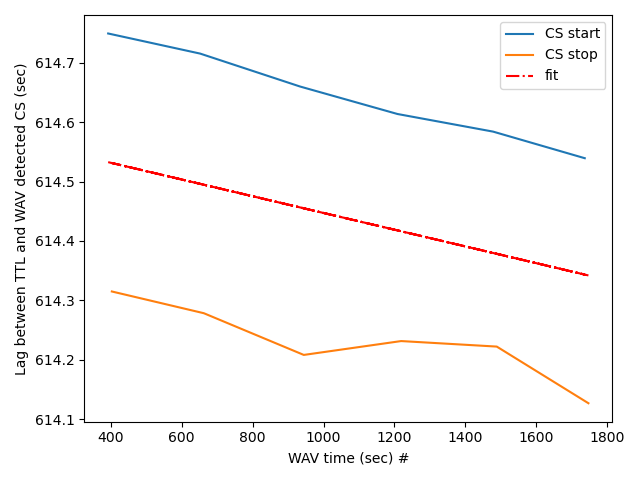

In [40]:
from scipy.linalg import lstsq

_, ax = plt.subplots(layout='tight')
cs_times_wav = np.stack((cs_wav_epochs.starts, cs_wav_epochs.stops), axis=1)
cs_lags_comb = np.stack((cs_start_lags, cs_stop_lags), axis=1)
hl = ax.plot(cs_times_wav, cs_lags_comb)
ax.set_xlabel('WAV time (sec) #')
ax.set_ylabel('Lag between TTL and WAV detected CS (sec)')
ax.legend(hl, ('CS Start', 'CS Stop'))

# Fit function to approximate drift
y = cs_lags_comb.T.reshape(-1)
M = np.stack((np.ones_like(cs_lags_comb.reshape(-1)), cs_times_wav.T.reshape(-1)), axis=1)
p, res, rnk, s = lstsq(M, y)
hfit = ax.plot(cs_times_wav.T.reshape(-1), p[0] + p[1]*cs_times_wav.T.reshape(-1), 'r-.')
hl.extend(hfit)
ax.legend(hl, ('CS start', 'CS stop', 'fit'))

In [41]:
# Sanity check code to output corrected CS times from WAV file to Neuroscope
cs_wav_starts_aligned = cs_wav_epochs.starts + p[0] + p[1]*cs_wav_epochs.starts
cs_wav_stops_aligned = cs_wav_epochs.stops + p[0] + p[1]*cs_wav_epochs.stops
cs_wav_epochs_aligned = Epoch({"start": cs_wav_starts_aligned, "stop": cs_wav_stops_aligned, 
                               "label": ["CS+ from WAV file"]*len(cs_wav_stops_aligned)})


cs_epochs_files = sess.filePrefix.with_suffix(".cs_wav_epochs.npy")
cs_wav_epochs_aligned.save(cs_epochs_files)
sess.recinfo.write_epochs(cs_wav_epochs_aligned, ext="wv+")

/data3/Trace_FC/Recording_Rats/Finn2/2023_05_08_training/Finn2_training_denoised.cs_wav_epochs.npy saved


In [42]:
cs_wav_epochs_aligned

6 epochs
Snippet: 
          start         stop              label
0  1006.663717  1017.013160  CS+ from WAV file
1  1266.342174  1276.711389  CS+ from WAV file
2  1548.380405  1558.769955  CS+ from WAV file
3  1823.304638  1833.606110  CS+ from WAV file
4  2093.123859  2103.425499  CS+ from WAV file

Now correct that drift and find corrected lags!

In [43]:
# This should eventually be folded into the DeepSqueakIO class!
calls_accept_df = ds_calls.usv_df[ds_calls.usv_df['Accept'] == 1]
call_starts_wav = calls_accept_df['Begin_Time'].values
call_stops_wav = call_starts_wav + calls_accept_df['Duration'].values
calls_accept_df.insert(0, "start", call_starts_wav + p[0] + p[1]*call_starts_wav)
calls_accept_df.insert(1, "stop", call_stops_wav + p[0] + p[1]*call_stops_wav)
calls_accept_df.insert(calls_accept_df.shape[1], "label", "")
good_calls = Epoch(calls_accept_df)

# output to neuroscope and neuropy
sess.recinfo.write_epochs(good_calls, ext="usv")
usv_epochs_file = sess.filePrefix.with_suffix(".usv_epochs.npy")
good_calls.save(usv_epochs_file)

/data3/Trace_FC/Recording_Rats/Finn2/2023_05_08_training/Finn2_training_denoised.usv_epochs.npy saved


In [44]:
good_calls

457 epochs
Snippet: 
         start        stop  Begin_Time   Freq_Min  Duration  Freq_Range  Score  \
0  652.529394  652.563925   37.946853  39.274313  0.034535   20.924947    1.0   
1  652.676857  652.722485   38.094337  40.405391  0.045634   18.889006    1.0   
2  653.508978  653.542528   38.926574  46.196915  0.033555   12.441860    1.0   
3  655.169906  655.224620   40.587737  39.726744  0.054721   17.418605    1.0   
4  656.243937  656.292611   41.661918  37.917019  0.048681   41.171247    1.0   

   Accept label  
0       1        
1       1        
2       1        
3       1        
4       1        

## Save notebook to working directory

In [45]:
from neuropy.core.session import ProcessData

def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)

In [46]:
pip install jupyter-save-load-vars

Note: you may need to restart the kernel to use updated packages.


In [47]:
import neuropy.io.openephysio as oeio
sync_df = oeio.create_sync_df(sess.basepath)
sync_df["Time since rec start (sec)"] = (sync_df['Datetime'] - sync_df.loc[0, 'Datetime']).dt.total_seconds()
sync_df

start time = 2023-05-08 11:54:10-04:00
start time = 2023-05-08 12:04:32-04:00
start time = 2023-05-08 12:41:12-04:00
start time = 2023-05-08 14:15:17-04:00
start time = 2023-05-08 15:12:40-04:00


,Recording,Datetime,Condition,nframe_dat,dat_time,nframe_eeg,eeg_time,Time since rec start (sec)
0,0,2023-05-08 11:54:10-04:00,start,0,0.000000,0,0.0000,0.000000
1,0,2023-05-08 12:03:14.375433333-04:00,stop,16331263,544.375433,680469,544.3752,544.375433
2,1,2023-05-08 12:04:32-04:00,start,16331264,544.375467,680470,544.3760,622.000000
3,1,2023-05-08 12:40:06.536500-04:00,stop,80367359,2678.911967,3348639,2678.9112,2756.536500
4,2,2023-05-08 12:41:12-04:00,start,80367360,2678.912000,3348640,2678.9120,2822.000000
5,2,2023-05-08 14:13:58.532233333-04:00,stop,247363327,8245.444233,10306805,8245.4440,8388.532233
6,3,2023-05-08 14:15:17-04:00,start,247363328,8245.444267,10306806,8245.4448,8467.000000
7,3,2023-05-08 15:11:31.677300-04:00,stop,348603647,11620.121567,14525151,11620.1208,11841.677300
8,4,2023-05-08 15:12:40-04:00,start,348603648,11620.121600,14525152,11620.1216,11910.000000
9,4,2023-05-08 17:16:04.680500-04:00,stop,570744063,19024.802100,23781002,19024.8016,19314.680500


In [48]:
import neuropy.io.miniscopeio as miniio
mini = miniio.MiniscopeIO(sess.basepath)

In [49]:
mini.load_all_orientation()
mini.load_all_timestamps()

including folder /data3/Trace_FC/Recording_Rats/Finn2/2023_05_08_training/1_tone_habituation/tone_habituation/Finn2/gobears/2023_05_08/11_55_32
including folder /data3/Trace_FC/Recording_Rats/Finn2/2023_05_08_training/2_training/training/Finn2/gobears/2023_05_08/12_06_09
including folder /data3/Trace_FC/Recording_Rats/Finn2/2023_05_08_training/3_post/post/Finn2/gobears/2023_05_08/12_42_30
including folder /data3/Trace_FC/Recording_Rats/Finn2/2023_05_08_training/3_post/post/Finn2/gobears/2023_05_08/13_09_45
including folder /data3/Trace_FC/Recording_Rats/Finn2/2023_05_08_training/3_post/post/Finn2/gobears/2023_05_08/13_30_33
including folder /data3/Trace_FC/Recording_Rats/Finn2/2023_05_08_training/3_post/post/Finn2/gobears/2023_05_08/13_45_30
including folder /data3/Trace_FC/Recording_Rats/Finn2/2023_05_08_training/3_post/post/Finn2/gobears/2023_05_08/14_01_19
including folder /data3/Trace_FC/Recording_Rats/Finn2/2023_05_08_training/3_post/post/Finn2/gobears/2023_05_08/14_15_38
includin

,Frame Number,Time Stamp (ms),Buffer Index,Timestamps
0,0,-63,0,2023-05-08 11:55:32.880
1,1,29,0,2023-05-08 11:55:32.972
2,2,72,0,2023-05-08 11:55:33.015
3,3,138,0,2023-05-08 11:55:33.081
4,4,205,0,2023-05-08 11:55:33.148
...,...,...,...,...
14249,14249,960008,0,2023-05-08 17:15:58.174
14250,14250,960075,0,2023-05-08 17:15:58.241
14251,14251,960143,0,2023-05-08 17:15:58.309
14252,14252,960210,0,2023-05-08 17:15:58.376


In [50]:
rough_headsensor_times = (mini.orient_all["Timestamps"].dt.tz_localize(tz="America/Detroit") - sync_df.loc[0, "Datetime"]).dt.total_seconds()
mini.orient_all["Rough eeg time (s)"] = rough_headsensor_times
mini.orient_all

,Time Stamp (ms),qw,qx,qy,qz,Timestamps,roll,pitch,yaw,Rough eeg time (s)
0,-63,-0.452881,0.275818,0.001160,-0.847839,2023-05-08 11:55:32.880,-0.288682,0.485490,2.088444,82.880
1,29,-0.426147,0.277771,0.043945,-0.859802,2023-05-08 11:55:32.972,-0.355253,0.455861,2.138026,82.972
2,72,-0.411499,0.267334,0.064941,-0.868896,2023-05-08 11:55:33.015,-0.373802,0.423689,2.175700,83.015
3,138,-0.488342,0.259521,0.083984,-0.828918,2023-05-08 11:55:33.081,-0.432258,0.355675,1.997920,83.081
4,205,-0.557434,0.244263,0.035156,-0.792664,2023-05-08 11:55:33.148,-0.357503,0.355506,1.850860,83.148
...,...,...,...,...,...,...,...,...,...,...
14249,960008,-0.957947,0.040649,0.016724,-0.283447,2023-05-08 17:15:58.174,-0.087476,-0.008997,0.575723,19308.174
14250,960075,-0.958008,0.040588,0.016907,-0.283264,2023-05-08 17:15:58.241,-0.087461,-0.009399,0.575363,19308.241
14251,960143,-0.958008,0.040710,0.016846,-0.283264,2023-05-08 17:15:58.309,-0.087661,-0.009213,0.575360,19308.309
14252,960210,-0.958008,0.040710,0.016724,-0.283264,2023-05-08 17:15:58.376,-0.087592,-0.008979,0.575347,19308.376


In [51]:
rough_headsensor_times = (mini.orient_all["Timestamps"].dt.tz_localize(tz="America/Detroit") - sync_df.loc[0, "Datetime"]).dt.total_seconds()
mini.orient_all["Time from OE start"] = rough_headsensor_times
mini.orient_all

# Key line of code - converts miniscope time (which doesn't account for disconnects) to eeg time (which cuts out disconnect times)
mini.orient_all["Rough eeg time (s)"] = np.interp(mini.orient_all["Time from OE start"], sync_df["Time since rec start (sec)"], 
                                            sync_df["eeg_time"])
mini.orient_all

,Time Stamp (ms),qw,qx,qy,qz,Timestamps,roll,pitch,yaw,Rough eeg time (s),Time from OE start
0,-63,-0.452881,0.275818,0.001160,-0.847839,2023-05-08 11:55:32.880,-0.288682,0.485490,2.088444,82.879964,82.880
1,29,-0.426147,0.277771,0.043945,-0.859802,2023-05-08 11:55:32.972,-0.355253,0.455861,2.138026,82.971964,82.972
2,72,-0.411499,0.267334,0.064941,-0.868896,2023-05-08 11:55:33.015,-0.373802,0.423689,2.175700,83.014964,83.015
3,138,-0.488342,0.259521,0.083984,-0.828918,2023-05-08 11:55:33.081,-0.432258,0.355675,1.997920,83.080964,83.081
4,205,-0.557434,0.244263,0.035156,-0.792664,2023-05-08 11:55:33.148,-0.357503,0.355506,1.850860,83.147964,83.148
...,...,...,...,...,...,...,...,...,...,...,...
14249,960008,-0.957947,0.040649,0.016724,-0.283447,2023-05-08 17:15:58.174,-0.087476,-0.008997,0.575723,19018.295100,19308.174
14250,960075,-0.958008,0.040588,0.016907,-0.283264,2023-05-08 17:15:58.241,-0.087461,-0.009399,0.575363,19018.362100,19308.241
14251,960143,-0.958008,0.040710,0.016846,-0.283264,2023-05-08 17:15:58.309,-0.087661,-0.009213,0.575360,19018.430100,19308.309
14252,960210,-0.958008,0.040710,0.016724,-0.283264,2023-05-08 17:15:58.376,-0.087592,-0.008979,0.575347,19018.497100,19308.376


In [52]:
cs_epochs_file = sess.filePrefix.with_suffix(".cs_epochs.npy")
sess.cs_epochs = Epoch(epochs=None, file=cs_epochs_file)
sess.cs_epochs.starts

array([1006.880366, 1266.5615  , 1548.583966, 1823.500633, 2093.328166,
       2352.006833])

In [53]:
csn_epochs_file = sess.filePrefix.with_suffix(".csn_epochs.npy")
sess.csn_epochs = Epoch(epochs=None, file=csn_epochs_file)
sess.csn_epochs.starts

array([144.406266, 224.345733, 298.210033, 360.911933, 440.835733])

AttributeError: 'ProcessData' object has no attribute 'cs2_epochs'

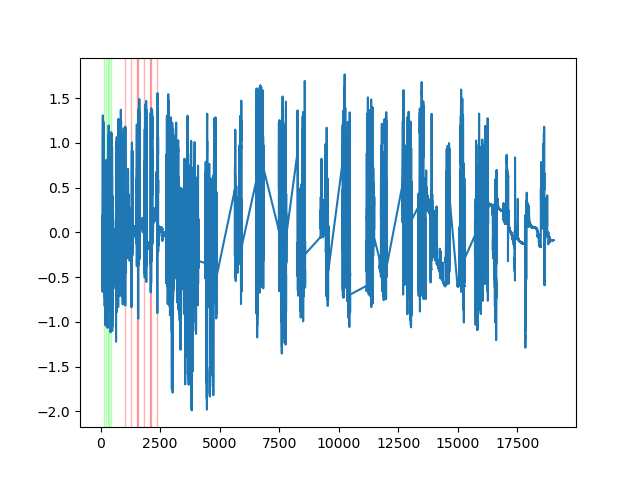

In [56]:
%matplotlib widget
_, ax = plt.subplots()
ax.plot(mini.orient_all["Rough eeg time (s)"], mini.orient_all.roll)
for start, stop in zip(sess.cs_epochs.starts, sess.cs_epochs.stops):
    ax.axvspan(start, stop, color=[1, 0, 0, 0.3])

for start, stop in zip(sess.csn_epochs.starts, sess.csn_epochs.stops):
    ax.axvspan(start, stop, color=[0, 1 , 0, 0.3])

for start, stop in zip(sess.cs2_epochs.starts, sess.cs2_epochs.stops):
    ax.axvspan(start, stop, color=[1, 0, 0, 0.3])

In [57]:
def calc_head_speed(df):

    angle_diffs = []
    for ang_axis in ["roll", "pitch", "yaw"]:
        axis_diff = df[ang_axis].diff()

        # Correct any swings of > 2*pi
        axis_diff[axis_diff > 1.8 * np.pi] = axis_diff[axis_diff > 1.8 * np.pi] - 2 * np.pi
        axis_diff[axis_diff < -1.8 * np.pi] = axis_diff[axis_diff < -1.8 * np.pi] + 2 * np.pi
        angle_diffs.append(axis_diff.values)
    # head_speed = np.sqrt(np.square(df.roll.diff()) + np.square(df.pitch.diff()) + np.square(df.yaw.diff())) / df["Rough eeg time (s)"].diff()
    head_speed = np.sqrt(np.square(angle_diffs[0]) + np.square(angle_diffs[1]) + np.square(angle_diffs[2]))
    return head_speed
calc_head_speed(mini.orient_all)

array([       nan, 0.0881366 , 0.05289931, ..., 0.00027301, 0.00024443,
       0.00038601])

AttributeError: 'ProcessData' object has no attribute 'cs2_epochs'

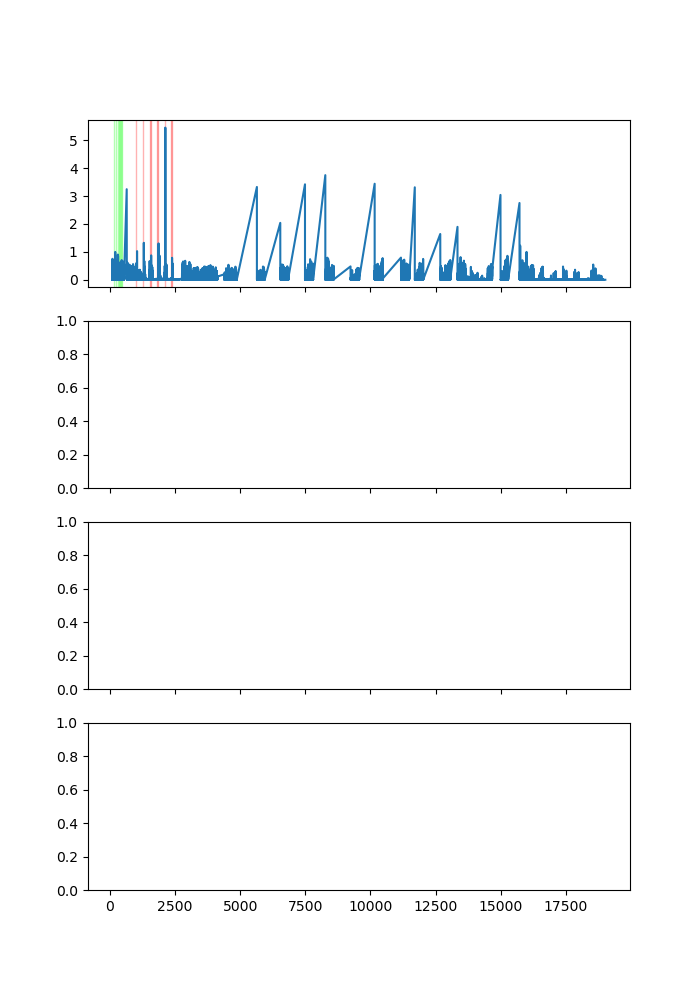

In [63]:
%matplotlib widget
_, axs = plt.subplots(4, 1, figsize=(7, 10), sharex=True)
ax = axs[0]
mini.orient_all["Head speed"] = calc_head_speed(mini.orient_all)
ax.plot(mini.orient_all["Rough eeg time (s)"], mini.orient_all["Head speed"])
for start, stop in zip(sess.cs_epochs.starts, sess.cs_epochs.stops):
    ax.axvspan(start, stop, color=[1, 0, 0, 0.3])

for start, stop in zip(sess.csn_epochs.starts, sess.csn_epochs.stops):
    ax.axvspan(start, stop, color=[0, 1, 0, 0.3])

for start, stop in zip(sess.cs2_epochs.starts, sess.cs2_epochs.stops):
    ax.axvspan(start, stop, color=[1, 0, 0, 0.3])


/tmp/ipykernel_540145/1303755923.py:41: RuntimeWarning: Mean of empty slice
  average_speed = np.nanmean(all_speeds, axis=0)


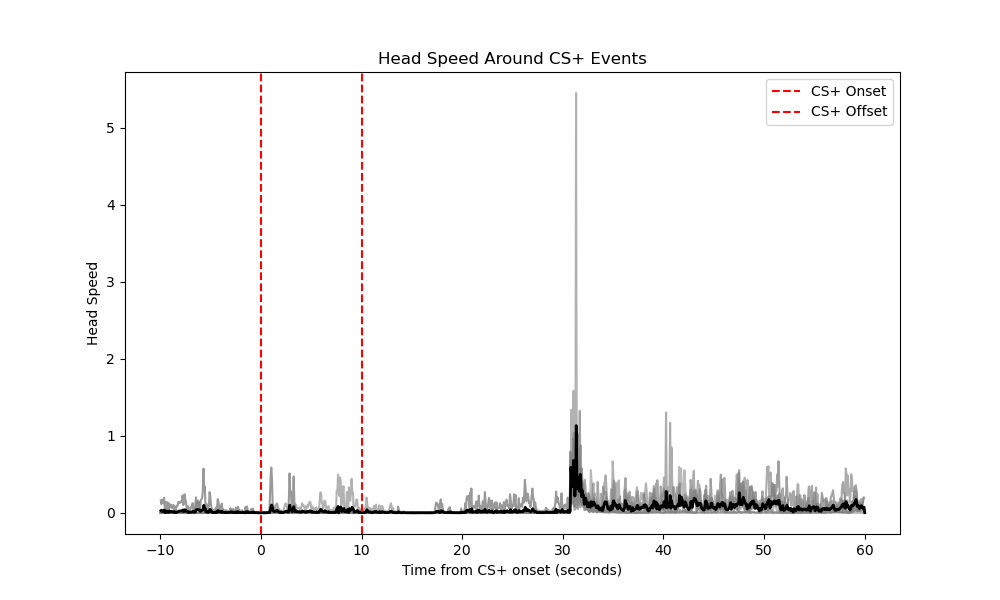

In [68]:
import matplotlib.pyplot as plt
import numpy as np
epochs_use = sess.cs_epochs

start_buffer, stop_buffer = 10, 50
times_all=[]
# sampling_rate = 30 
eeg_times = mini.orient_all["Rough eeg time (s)"]
mini_sr = 15 # fps

fig, ax = plt.subplots(figsize=(10, 6))
# all_speeds, times_all = [], []

# Set up theoretical time bins
tinterp = np.arange(-start_buffer, (10 + stop_buffer) + 1/ mini_sr, 1/mini_sr)

# Pre-allocate speeds array
all_speeds = np.ones((epochs_use.n_epochs, len(tinterp)))*np.nan

# Loop through each CS+ event
for idt, (start, stop) in enumerate(zip(epochs_use.starts, epochs_use.stops)):

    # Perfect code for getting eeg signal data relative to CS times
    # start_idx = int((start - 5) * sampling_rate)  
    # stop_idx = int((start + 15) * sampling_rate)  
    # times = np.linspace(-5, 15, stop_idx - start_idx)
    # speeds = mini.orient_all["Head speed"][start_idx:stop_idx]

    # This code gets miniscope data relative to CS times
    trial_bool = (eeg_times > (start - start_buffer)) & (eeg_times < (stop + stop_buffer))
    speeds = mini.orient_all.loc[trial_bool, "Head speed"].values
    times = mini.orient_all.loc[trial_bool, "Rough eeg time (s)"].values - start
    times_all.append(times)
    ax.plot(times, speeds, color='grey', alpha=0.8 - idt*0.05) 
    # all_speeds.append(speeds)

    # Fill in speeds at all time points
    data_bin_id = np.digitize(times, tinterp)  # identify time bins for each data point
    all_speeds[idt, data_bin_id] = speeds

average_speed = np.nanmean(all_speeds, axis=0) 
ax.plot(tinterp, average_speed, color='black', linewidth=2) 

ax.axvline(x=0, color='red', linestyle='--', label='CS+ Onset')
ax.axvline(x=10, color='red', linestyle='--', label='CS+ Offset')

ax.set_xlabel('Time from CS+ onset (seconds)')
ax.set_ylabel('Head Speed')
ax.set_title('Head Speed Around CS+ Events')
ax.legend() 

plt.show()

/tmp/ipykernel_540145/381692451.py:39: RuntimeWarning: Mean of empty slice
  average_speed = np.nanmean(all_speeds, axis=0)


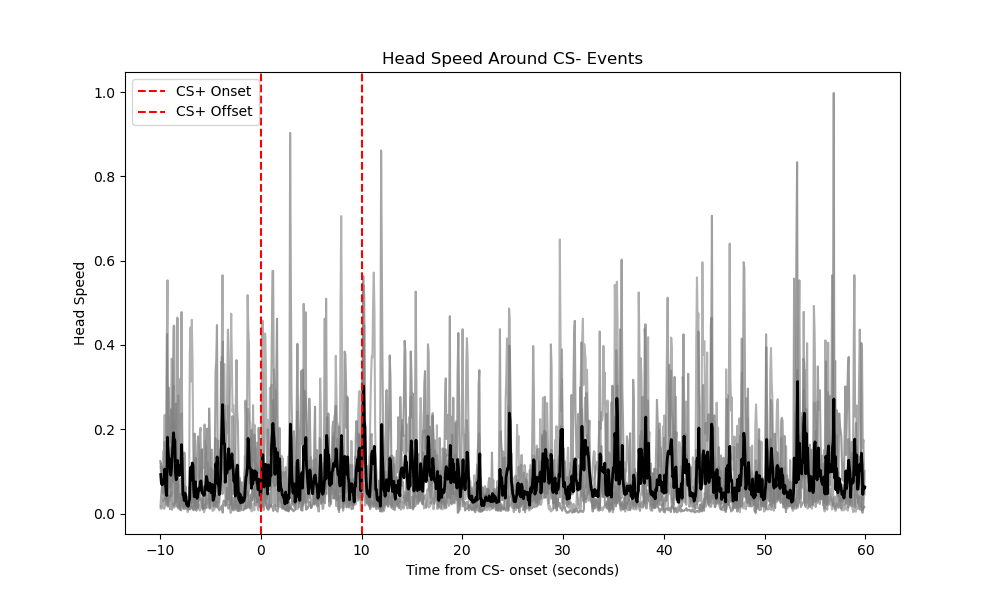

In [69]:
import matplotlib.pyplot as plt
import numpy as np
epochs_use = sess.csn_epochs

# sampling_rate = 30 
eeg_times = mini.orient_all["Rough eeg time (s)"]
mini_sr = 15 # fps

fig, ax = plt.subplots(figsize=(10, 6))
# all_speeds, times_all = [], []

# Set up theoretical time bins
tinterp = np.arange(-start_buffer, (10 + stop_buffer) + 1/ mini_sr, 1/mini_sr)

# Pre-allocate speeds array
all_speeds = np.ones((epochs_use.n_epochs, len(tinterp)))*np.nan

# Loop through each CS+ event
for idt, (start, stop) in enumerate(zip(epochs_use.starts, epochs_use.stops)):

    # Perfect code for getting eeg signal data relative to CS times
    # start_idx = int((start - 5) * sampling_rate)  
    # stop_idx = int((start + 15) * sampling_rate)  
    # times = np.linspace(-5, 15, stop_idx - start_idx)
    # speeds = mini.orient_all["Head speed"][start_idx:stop_idx]

    # This code gets miniscope data relative to CS times
    trial_bool = (eeg_times > (start - start_buffer)) & (eeg_times < (stop + stop_buffer))
    speeds = mini.orient_all.loc[trial_bool, "Head speed"].values
    times = mini.orient_all.loc[trial_bool, "Rough eeg time (s)"].values - start
    times_all.append(times)
    ax.plot(times, speeds, color='grey', alpha=0.8 - idt*0.05) 
    # all_speeds.append(speeds)

    # Fill in speeds at all time points
    data_bin_id = np.digitize(times, tinterp)  # identify time bins for each data point
    all_speeds[idt, data_bin_id] = speeds

average_speed = np.nanmean(all_speeds, axis=0) 
ax.plot(tinterp, average_speed, color='black', linewidth=2) 

ax.axvline(x=0, color='red', linestyle='--', label='CS+ Onset')
ax.axvline(x=10, color='red', linestyle='--', label='CS+ Offset')

ax.set_xlabel('Time from CS- onset (seconds)')
ax.set_ylabel('Head Speed')
ax.set_title('Head Speed Around CS- Events')
ax.legend() 

plt.show()